### Natural Language Processing Script

This script can be used as a standalone program to process and prepare topic modelling of the ```Scraper.py``` datasets generated.

### 1.0 <u>Code:</u>

Here, we import the libraries required to run the script.

In [1]:
'''Natural Language toolkit. Here we download the commonly used English stopwords'''
import nltk; nltk.download('stopwords')
'''Standard set of functions for reading and appending files'''
import re
'''Pandas and numpy is a dependency used by other portions of the code.'''
import numpy as np
import pandas as pd
'''Think this stands for pretty print. Prints out stuff to the terminal in a prettier way'''
from pprint import pprint

'''Contains the language model that has to be developed.'''
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
'''Industrial level toolkit for NLP'''
import spacy

'''Importing OS here to build the directories to hold the status logger logs'''
import os

import pyLDAvis
import pyLDAvis.gensim

'''Importing datetime here to log the time when specfic functions are triggered'''
from datetime import datetime

'''Make pretty visualizations'''
import matplotlib.pyplot as plt

'''Library to log any errors. Came across this in the tutorial.'''
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'com', 'https', 'url', 'link', 'xe', 'abstract', 'author', 'chapter', 'springer', 'title', "the", "of", "and", "in", "to", "a", "is", "for", "from", "with", "that","by", "are", "on", "was", "as", "were", "url:", "abstract:", "abstract",  "author:", "title:", "at", "be", "an", "during", "have", "this", "which", "study", "been", "species", "not", "has", "between", "using", "its", "also", "these", "this", "used", "over", "can", "within", "into", "all","due", "use", "about", "a", 'it', 'their', "where", "we", "most", "may", "through", "though", "like", "or", "further", "e.g.", "along", "any", "those", "had", "toward", "due", "both", "some", "use", "even", "more", "but", "while", "pass", "well", "will", "when", "only", "after", "author", "title", "there", "our", "did", "much", "as", "if", "become", "still", "various", "very", "out", "they", "via", "available", "such", "than", "different", "many", "areas", "no", "one", "two", "small", "first", "other", "such", "-", "could", "studies", "high","provide", "among", "highly", "no", "case", "across", "given", "need", "would", "under", "found", "low", "values", "xe2\\x80\\x89"])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sarthak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Defining the abstracts log name that will be processed by the rest of the script. The status logger function of the main script has been imported here, and the name of the ```.txt``` file used to log the information has to be added here.

In [2]:
abstracts_log_name = "/home/sarthak/projects/Bias/BackUp_Journal_LOGS/Test_Bed_Master_Copy/No_Special_Characters_Corpus"
session_folder_name = abstracts_log_name.split('/')[7]
os.makedirs(session_folder_name)
status_logger_name = session_folder_name+"/"+"Status_Logger"+"_"+abstracts_log_name.split('/')[7]

This function is responsible for generating a ```.txt``` file for analysis once the code has run. This code has been copied directly from the ```common_functions.py``` script of the main code.

In [3]:
def status_logger(status_logger_name, status_key):
	'''Status logger to print and log details throught the running the program.
	Declaring current_hour, current_minute & current_second.'''
	current_hour = str(datetime.now().time().hour)
	current_minute = str(datetime.now().time().minute)
	current_second = str(datetime.now().time().second)
	'''Logging the complete_status_key and printing the complete_status_key'''
	complete_status_key = "[INFO]"+current_hour+":"+current_minute+":"+current_second+" "+status_key
	print(complete_status_key)
	status_log = open(status_logger_name+'.txt', 'a')
	status_log.write(complete_status_key+"\n")
	status_log.close()

Here, we read the ```.txt``` file generated from the journal scrapping, that has to be profiled using topic models.

In [4]:
def data_reader(abstracts_log_name, status_logger_name):
	data_reader_start_status_key = abstracts_log_name+".txt is being ported to dataframe"
	status_logger(status_logger_name, data_reader_start_status_key)
	textual_dataframe = pd.read_csv(abstracts_log_name+'.txt', delimiter="\t")
	data_reader_end_status_key = abstracts_log_name+".txt has been ported to dataframe"	
	status_logger(status_logger_name, data_reader_end_status_key)
	return textual_dataframe

Taking the abstracts and preparing a list of abstracts.

In [5]:
def textual_data_trimmer(textual_dataframe, status_logger_name):
	textual_data_trimmer_start_status_key = "Trimming data and preparing list of words"
	status_logger(status_logger_name, textual_data_trimmer_start_status_key)

	'''This function converts the textual data into a list and removes special characters, virtue of email correspondence'''
	textual_data = textual_dataframe.values.tolist()
	print(textual_data)

	textual_data_trimmer_end_status_key = "Trimmed data and prepared list of words"
	status_logger(status_logger_name, textual_data_trimmer_end_status_key)
	return textual_data

Tokenizing the words here and also removing punctuations from the corpus.

In [6]:
def sent_to_words(textual_data, status_logger_name):
	sent_to_words_start_status_key = "Tokenizing words"
	status_logger(status_logger_name, sent_to_words_start_status_key)
	'''This function tokenizes each sentence into individual words; also called tokens'''
	for sentence in textual_data:
		yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
	textual_data = list(sent_to_words(textual_data))
	sent_to_words_end_status_key = "Tokenized words"
	status_logger(status_logger_name, sent_to_words_end_status_key)	
	return textual_data

Generating ***```bigrams```*** from the ```textual_data``` that we have prepared from the abstracts. **Bigrams** are words that occur together, multiple times in a given body of text. For example, *torrential* and *rain* occur together more often with each other, as opposed to other adjective-noun pairs. Hence the two would form a bigram here.

In [7]:
def bigram_generator(textual_data, status_logger_name):
	bigram_generator_start_status_key = "Generating word bigrams"
	status_logger(status_logger_name, bigram_generator_start_status_key)	
	'''Takes the textual data and prepares the bigram, two collectively high frequency words'''
	bigram = gensim.models.Phrases(textual_data, min_count=5, threshold=100)
	bigram_mod = gensim.models.phrases.Phraser(bigram)
	bigram_generator_end_status_key = "Generated word bigrams"
	status_logger(status_logger_name, bigram_generator_end_status_key)	
	return bigram_mod

Here, we use the ```bigram_mod``` model to generate bigrams from our ```corpus```.

In [8]:
def make_bigrams(textual_data, status_logger_name):
	'''Generates multiple bigrams of word pairs in phrases that commonly occuring with each other over the corpus'''
	make_bigrams_start_status_key = "Generating bigrams"
	status_logger(status_logger_name, make_bigrams_start_status_key)

	bigram_mod = bigram_generator(textual_data, status_logger_name)
	return [bigram_mod[doc] for doc in textual_data]

	make_bigrams_end_status_key = "Generated bigrams"

We remove the stopwords, as specified in a list at the start of the program. There's a marked improvement in the topics and keywords produced after expanding the cache of the words to be filtered out.

In [9]:
def remove_stopwords(textual_data, status_logger_name):
	'''This function removes the standard set of stopwords from the corpus of abstract words'''
	remove_stopwords_start_status_key = "Removing stopwords"
	status_logger(status_logger_name, remove_stopwords_start_status_key)
	return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in textual_data]
	remove_stopwords_end_status_key = "Removed stopwords"
	status_logger(status_logger_name, remove_stopwords_end_status_key)

Generating the ```pyLDAvis``` visualization from the ```lda_model``` generated and trained on our ```corpus``` & ```id2word``` dictionary. The time taken here is proportional to the size of the ```corpus```.

In [10]:
def visualizer_generator(lda_model, corpus, id2word, logs_folder_name, status_logger_name):
	'''This code generates the .html file with generates the visualization of the data prepared.'''
	visualizer_generator_start_status_key = "Preparing the topic modeling visualization"
	status_logger(status_logger_name, visualizer_generator_start_status_key)
    
	textual_data_visualization = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
	pyLDAvis.save_html(textual_data_visualization, session_folder_name+'/'+"Data_Visualization_Topic_Modelling.html")

	visualizer_generator_end_status_key = "Prepared the topic modeling visualization"+" "+"Data_Visualization_Topic_Modelling.html"
	status_logger(status_logger_name, visualizer_generator_end_status_key)

Lemmatization involves truncating a term to its root term. For example *running -> run* is an example of the ```lemmatization``` process.

In [11]:
def lemmatization(status_logger_name, textual_data, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
	lemmatization_start_status_key = "Beginning lemmatization"
	status_logger(status_logger_name, lemmatization_start_status_key)
	"""https://spacy.io/api/annotation"""
	texts_out = []
	nlp = spacy.load('en', disable=['parser', 'ner'])
	for sent in textual_data:
		doc = nlp(" ".join(sent))
		texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
	lemmatization_end_status_key = "Ending lemmatization"
	status_logger(status_logger_name, lemmatization_end_status_key)
	return texts_out

Calling the ```nlp_engine_main()``` function where all the previously defined functions come together and generate the ```pyLDAvis``` visualization for topic analysis.

In [12]:
nlp_engine_main_start_status_key = "Initiating the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_start_status_key)

'''Extracts the data from the .txt file and puts them into a Pandas dataframe buckets'''
textual_dataframe = data_reader(abstracts_log_name, status_logger_name)
'''Rids the symbols and special characters from the textual_data'''
textual_data = textual_data_trimmer(textual_dataframe, status_logger_name)
'''Removes stopwords that were earlier downloaded from the textual_data'''
textual_data_no_stops = remove_stopwords(textual_data, status_logger_name)
'''Prepares bigrams'''
textual_data_words_bigrams = make_bigrams(textual_data_no_stops, status_logger_name)
'''Loads the English model from spaCy'''
nlp = spacy.load('en', disable=['parser', 'ner'])

textual_data_lemmatized = lemmatization(status_logger_name, textual_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

id2word = corpora.Dictionary(textual_data_lemmatized)

texts = textual_data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

'''Builds the actual LDA model that will be used for the visualization and inference'''
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = 12, random_state = 100, update_every = 1, chunksize = 100, passes = 10, alpha = 'symmetric', per_word_topics = True)

doc_lda = lda_model[corpus]

perplexity_score = lda_model.log_perplexity(corpus)

perplexity_status_key = "Issued perplexity:"+" "+str(perplexity_score)

status_logger(status_logger_name, perplexity_status_key)

nlp_engine_main_end_status_key = "Idling the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_end_status_key)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO]20:2:28 Generating bigrams
[INFO]20:2:28 Generating word bigrams
[INFO]20:2:37 Generated word bigrams
[INFO]20:2:39 Beginning lemmatization
[INFO]20:3:33 Ending lemmatization
[INFO]20:4:25 Issued perplexity: -9.376741605936553
[INFO]20:4:25 Idling the NLP Engine


In [13]:
lda_model

In [14]:
lda_model.print_topics()

[(0,
  '0.034*"diversity" + 0.026*"richness" + 0.018*"site" + 0.018*"plant" + 0.015*"habitat" + 0.014*"community" + 0.013*"number" + 0.012*"sample" + 0.012*"soil" + 0.011*"pattern"'),
 (1,
  '0.023*"bird" + 0.016*"change" + 0.016*"increase" + 0.014*"effect" + 0.013*"habitat" + 0.013*"year" + 0.013*"site" + 0.012*"decline" + 0.011*"people" + 0.011*"management"'),
 (2,
  '0.049*"biomass" + 0.048*"sea" + 0.033*"mangrove" + 0.030*"sediment" + 0.021*"substantial" + 0.021*"content" + 0.013*"divide" + 0.011*"estimator" + 0.010*"catalogue" + 0.008*"ranking"'),
 (3,
  '0.034*"model" + 0.031*"datum" + 0.030*"distribution" + 0.020*"method" + 0.018*"estimate" + 0.016*"base" + 0.015*"information" + 0.015*"collection" + 0.013*"endemic" + 0.012*"identify"'),
 (4,
  '0.076*"island" + 0.031*"endemic" + 0.028*"climatic" + 0.024*"lineage" + 0.019*"climate" + 0.016*"snail" + 0.015*"algae" + 0.015*"amazonia" + 0.013*"distribution" + 0.011*"change"'),
 (5,
  '0.035*"lichen" + 0.031*"woody" + 0.023*"bat" + 0

In [15]:
mallet_path = '/home/sarthak/projects/Bias/mallet-2.0.8/bin/mallet'

In [16]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=12, id2word=id2word)

In [17]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=textual_data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(10,
  [('forest', 0.16008154287706874),
   ('tree', 0.05066924170488989),
   ('stand', 0.014430943375982403),
   ('site', 0.012955661060593869),
   ('density', 0.012848367801292884),
   ('plantation', 0.012204608245486977),
   ('plot', 0.011560848689681071),
   ('tropical', 0.011507202060030579),
   ('disturbance', 0.011212145596952872),
   ('composition', 0.010863442504224672)]),
 (8,
  [('survey', 0.02517162471395881),
   ('number', 0.01861586987445111),
   ('sample', 0.01858494650256664),
   ('water', 0.0142556744387408),
   ('site', 0.012987816191477519),
   ('record', 0.01196734491929),
   ('estimate', 0.01100872039087142),
   ('river', 0.010421176325066485),
   ('collect', 0.00995732574679943),
   ('invertebrate', 0.009586245284185788)]),
 (9,
  [('population', 0.0647245616457269),
   ('bird', 0.03515118045008974),
   ('large', 0.01739610658566892),
   ('rate', 0.014662432693635234),
   ('decline', 0.012895209167472043),
   ('mammal', 0.012563854756316443),
   ('density', 0.011

In [18]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=textual_data):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=textual_data_lemmatized, start=2, limit=40, step=6)

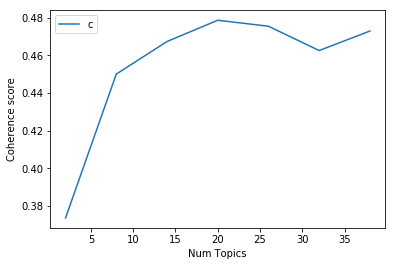

In [21]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [60]:
optimal_model = ldamallet

In [61]:
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=40))

[(0,
  '0.038*"vegetation" + 0.024*"community" + 0.023*"site" + 0.022*"grassland" + '
  '0.019*"soil" + 0.017*"change" + 0.017*"land" + 0.016*"plant" + '
  '0.014*"effect" + 0.013*"increase" + 0.013*"cover" + 0.012*"composition" + '
  '0.012*"management" + 0.010*"restoration" + 0.010*"type" + 0.009*"fire" + '
  '0.009*"significantly" + 0.008*"pasture" + 0.007*"abundance" + 0.007*"open" '
  '+ 0.007*"agricultural" + 0.007*"year" + 0.006*"arthropod" + '
  '0.006*"condition" + 0.006*"response" + 0.006*"shrub" + 0.006*"disturbance" '
  '+ 0.006*"ground" + 0.006*"affect" + 0.006*"riparian" + 0.005*"high" + '
  '0.005*"burn" + 0.005*"show" + 0.005*"significant" + 0.005*"plot" + '
  '0.005*"compare" + 0.005*"ecosystem" + 0.005*"result" + 0.005*"graze" + '
  '0.005*"difference"'),
 (1,
  '0.039*"region" + 0.034*"area" + 0.023*"endemic" + 0.023*"protect" + '
  '0.022*"conservation" + 0.018*"reserve" + 0.016*"threaten" + '
  '0.016*"distribution" + 0.016*"rare" + 0.013*"represent" + 0.011*"taxa"

In [62]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=textual_data)

In [63]:
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [64]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.5221,"model, distribution, datum, spatial, change, b...",[Abstract: 'Forests play a crucial role by reg...
1,1,4.0,0.3920,"diversity, richness, plant, group, pattern, co...",[Abstract: 'The analysis of species distributi...
2,2,5.0,0.2930,"model, distribution, datum, spatial, change, b...",[Abstract: 'The Himalayan ecosystem is one of ...
3,3,5.0,0.4371,"model, distribution, datum, spatial, change, b...","[Abstract: 'In an era of climate change, predi..."
4,4,5.0,0.2458,"model, distribution, datum, spatial, change, b...",[Abstract: 'The variation hypothesis assumes s...
5,5,4.0,0.3127,"diversity, richness, plant, group, pattern, co...",[Abstract: 'The evolutionary success of a spec...
6,6,5.0,0.4149,"model, distribution, datum, spatial, change, b...",[Abstract: 'The current study focuses on the i...
7,7,5.0,0.3789,"model, distribution, datum, spatial, change, b...",[Abstract: 'The objective of this research is ...
8,8,4.0,0.2445,"diversity, richness, plant, group, pattern, co...",[Abstract: 'The geographical patterns of speci...
9,9,3.0,0.2393,"plant, resource, wild, system, collection, imp...",[Abstract: 'Himalaya is endowed with a great d...


In [65]:
df_dominant_topic.to_csv(session_folder_name+'/Master_Topic_Per_Centence.csv')

In [66]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

In [67]:
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

In [68]:
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

In [69]:
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5798,"vegetation, community, site, grassland, soil, ...",[Abstract: 'Biological soil crusts (biocrusts)...
1,1.0,0.5865,"region, area, endemic, protect, conservation, ...",[Abstract: 'The family Caryophyllaceae include...
2,2.0,0.5388,"impact, native, island, insect, human, ecosyst...",[Abstract: 'To develop a risk-assessment syste...
3,3.0,0.5434,"plant, resource, wild, system, collection, imp...",[Abstract: 'We assessed the effectiveness of n...
4,4.0,0.4722,"diversity, richness, plant, group, pattern, co...","[Abstract: 'In this study, inter-simple sequen..."


In [70]:
sent_topics_sorteddf_mallet.to_csv(session_folder_name+'/Master_Topics_Contribution.csv')

In [71]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,5.0,"model, distribution, datum, spatial, change, b...",660.0,0.1522
1,4.0,"diversity, richness, plant, group, pattern, co...",303.0,0.0699
2,5.0,"model, distribution, datum, spatial, change, b...",296.0,0.0682
3,5.0,"model, distribution, datum, spatial, change, b...",277.0,0.0639
4,5.0,"model, distribution, datum, spatial, change, b...",297.0,0.0685
5,4.0,"diversity, richness, plant, group, pattern, co...",268.0,0.0618
6,5.0,"model, distribution, datum, spatial, change, b...",279.0,0.0643
7,5.0,"model, distribution, datum, spatial, change, b...",400.0,0.0922
8,4.0,"diversity, richness, plant, group, pattern, co...",321.0,0.0740
9,3.0,"plant, resource, wild, system, collection, imp...",335.0,0.0772


In [72]:
df_dominant_topics.to_csv(session_folder_name+'/Master_Topics.csv')

In [73]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

/home/sarthak/.local/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [74]:
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      24.424667        1       1  0.259621  0.024694
10     15.626496        1       2  0.182545 -0.171734
9      14.518316        1       3  0.190833 -0.083906
8      13.010171        1       4  0.199378 -0.002734
1      10.764371        1       5  0.146962  0.179004
6       9.405498        1       6  0.097458  0.295528
3       6.705945        1       7  0.061822 -0.224268
4       1.807169        1       8 -0.167036 -0.050565
5       1.308859        1       9 -0.235555  0.010139
11      1.047731        1      10 -0.241766  0.012940
7       0.953710        1      11 -0.244438  0.008494
2       0.427062        1      12 -0.249825  0.002408, topic_info=      Category         Freq            Term        Total  loglift  logprob
4804   Default  6384.000000          forest  6384.000000  30.0000  30.0000
13891  Default  1881.000000            tree  1881.000000  29.0000  29.0000
13268  Default  2504.000000      population  2504.000000  28.0000  28.0000
7041   Default  2931.000000        richness  2931.000000  27.0000  27.0000
17234  Default  4664.000000    conservation  4664.000000  26.0000  26.0000
16079  Default  4235.000000       diversity  4235.000000  25.0000  25.0000
16781  Default  1680.000000    distribution  1680.000000  24.0000  24.0000
2496   Default  3265.000000    biodiversity  3265.000000  23.0000  23.0000
22276  Default  1417.000000           datum  1417.000000  22.0000  22.0000
4811   Default  1129.000000         endemic  1129.000000  21.0000  21.0000
10593  Default  1156.000000           model  1156.000000  20.0000  20.0000
19260  Default  1385.000000         protect  1385.000000  19.0000  19.0000
7680   Default   627.000000          island   627.000000  18.0000  18.0000
15951  Default  1222.000000            bird  1222.000000  17.0000  17.0000
5103   Default  2933.000000            site  2933.000000  16.0000  16.0000
17637  Default   478.000000            seed   478.000000  15.0000  15.0000
16607  Default  4258.000000         habitat  4258.000000  14.0000  14.0000
14217  Default  3075.000000           plant  3075.000000  13.0000  13.0000
12787  Default  1024.000000         reserve  1024.000000  12.0000  12.0000
13232  Default  1413.000000          change  1413.000000  11.0000  11.0000
16848  Default  1528.000000          sample  1528.000000  10.0000  10.0000
20415  Default  1240.000000            base  1240.000000   9.0000   9.0000
21467  Default  1286.000000            soil  1286.000000   8.0000   8.0000
16643  Default  1846.000000      management  1846.000000   7.0000   7.0000
13587  Default   801.000000          method   801.000000   6.0000   6.0000
19496  Default  1079.000000            taxa  1079.000000   5.0000   5.0000
15162  Default   815.000000        estimate   815.000000   4.0000   4.0000
433    Default   762.000000         genetic   762.000000   3.0000   3.0000
4592   Default   870.000000     information   870.000000   2.0000   2.0000
17701  Default  1533.000000          region  1533.000000   1.0000   1.0000
...        ...          ...             ...          ...      ...      ...
19778  Topic12    64.830643        mangrove    66.113358   5.4364  -3.4026
3464   Topic12    58.935871        sediment    60.218586   5.4345  -3.4980
18650  Topic12    41.086460     substantial    42.369205   5.4253  -3.8587
14922  Topic12    41.077595         content    42.360336   5.4252  -3.8590
20879  Topic12    25.904619          divide    27.187357   5.4077  -4.3200
9018   Topic12    22.216124       estimator    23.498837   5.3999  -4.4736
9310   Topic12    19.171373       catalogue    20.454170   5.3912  -4.6210
19514  Topic12    15.921502         ranking    17.204264   5.3785  -4.8067
8362   Topic12    15.723841      home_range    17.006561   5.3776  -4.8192
16986  Topic12    14.973027      polychaete    16.255737   5.3738  -4.8682
16659  Topic12    13.964909      escarpment    15.2

In [75]:
pyLDAvis.save_html(vis, session_folder_name+'/Master.html')

In [76]:
pyLDAvis.enable_notebook()

In [77]:
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      24.424667        1       1  0.259621  0.024694
10     15.626496        1       2  0.182545 -0.171734
9      14.518316        1       3  0.190833 -0.083906
8      13.010171        1       4  0.199378 -0.002734
1      10.764371        1       5  0.146962  0.179004
6       9.405498        1       6  0.097458  0.295528
3       6.705945        1       7  0.061822 -0.224268
4       1.807169        1       8 -0.167036 -0.050565
5       1.308859        1       9 -0.235555  0.010139
11      1.047731        1      10 -0.241766  0.012940
7       0.953710        1      11 -0.244438  0.008494
2       0.427062        1      12 -0.249825  0.002408, topic_info=      Category         Freq            Term        Total  loglift  logprob
4804   Default  6384.000000          forest  6384.000000  30.0000  30.0000
13891  Default  1881.000000            tree  1881.000000  29.0000  29.0000
13268  Default  2504.000000      population  2504.000000  28.0000  28.0000
7041   Default  2931.000000        richness  2931.000000  27.0000  27.0000
17234  Default  4664.000000    conservation  4664.000000  26.0000  26.0000
16079  Default  4235.000000       diversity  4235.000000  25.0000  25.0000
16781  Default  1680.000000    distribution  1680.000000  24.0000  24.0000
2496   Default  3265.000000    biodiversity  3265.000000  23.0000  23.0000
22276  Default  1417.000000           datum  1417.000000  22.0000  22.0000
4811   Default  1129.000000         endemic  1129.000000  21.0000  21.0000
10593  Default  1156.000000           model  1156.000000  20.0000  20.0000
19260  Default  1385.000000         protect  1385.000000  19.0000  19.0000
7680   Default   627.000000          island   627.000000  18.0000  18.0000
15951  Default  1222.000000            bird  1222.000000  17.0000  17.0000
5103   Default  2933.000000            site  2933.000000  16.0000  16.0000
17637  Default   478.000000            seed   478.000000  15.0000  15.0000
16607  Default  4258.000000         habitat  4258.000000  14.0000  14.0000
14217  Default  3075.000000           plant  3075.000000  13.0000  13.0000
12787  Default  1024.000000         reserve  1024.000000  12.0000  12.0000
13232  Default  1413.000000          change  1413.000000  11.0000  11.0000
16848  Default  1528.000000          sample  1528.000000  10.0000  10.0000
20415  Default  1240.000000            base  1240.000000   9.0000   9.0000
21467  Default  1286.000000            soil  1286.000000   8.0000   8.0000
16643  Default  1846.000000      management  1846.000000   7.0000   7.0000
13587  Default   801.000000          method   801.000000   6.0000   6.0000
19496  Default  1079.000000            taxa  1079.000000   5.0000   5.0000
15162  Default   815.000000        estimate   815.000000   4.0000   4.0000
433    Default   762.000000         genetic   762.000000   3.0000   3.0000
4592   Default   870.000000     information   870.000000   2.0000   2.0000
17701  Default  1533.000000          region  1533.000000   1.0000   1.0000
...        ...          ...             ...          ...      ...      ...
19778  Topic12    64.830643        mangrove    66.113358   5.4364  -3.4026
3464   Topic12    58.935871        sediment    60.218586   5.4345  -3.4980
18650  Topic12    41.086460     substantial    42.369205   5.4253  -3.8587
14922  Topic12    41.077595         content    42.360336   5.4252  -3.8590
20879  Topic12    25.904619          divide    27.187357   5.4077  -4.3200
9018   Topic12    22.216124       estimator    23.498837   5.3999  -4.4736
9310   Topic12    19.171373       catalogue    20.454170   5.3912  -4.6210
19514  Topic12    15.921502         ranking    17.204264   5.3785  -4.8067
8362   Topic12    15.723841      home_range    17.006561   5.3776  -4.8192
16986  Topic12    14.973027      polychaete    16.255737   5.3738  -4.8682
16659  Topic12    13.964909      escarpment    15.2